# Emotion Detection - Inference Notebook

Notebook ini akan mendemontrasikan bagaimana memakai YOLO model untuk mendeteksi emosi baik itu menggunakan: 
1. gambar,
2. video,
3. webcam

## Import Libraries

In [1]:
from ultralytics import YOLO
import cv2
import os
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image

## Load Trained Model

In [5]:
# Load the best model from training
MODEL_PATH = "runs-2\content\\runs\detect\\train\weights\\best.pt"

model = YOLO(MODEL_PATH)
print(f"Model loaded from: {MODEL_PATH}")
print(f"Model classes: {model.names}")

Model loaded from: runs-2\content\runs\detect\train\weights\best.pt
Model classes: {0: 'angry', 1: 'happy', 2: 'relax', 3: 'rock', 4: 'romantic', 5: 'sad', 6: 'surprise'}


## Inference on a Single Image


image 1/1 d:\FIle Aku\emotion-8\test\images\1a021cedde40904bcee401b1a11c1918f47d712da48d16434d5b4c79-angry_jpg.rf.a746d3975119afe32ad92066d68938e8.jpg: 640x640 1 angry, 29.1ms
Speed: 5.7ms preprocess, 29.1ms inference, 30.2ms postprocess per image at shape (1, 3, 640, 640)


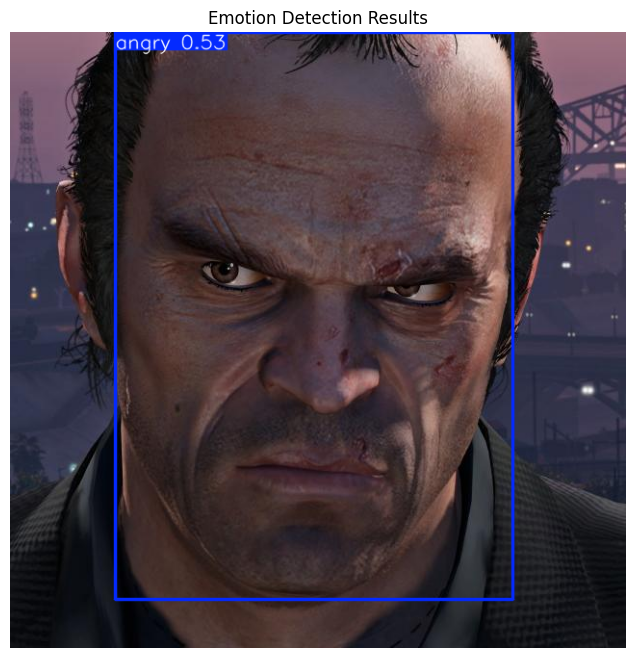


Detected 1 objects:
  - angry: 52.61%


In [7]:
# Specify image path
IMAGE_PATH = "emotion-8\\test\images\\1a021cedde40904bcee401b1a11c1918f47d712da48d16434d5b4c79-angry_jpg.rf.a746d3975119afe32ad92066d68938e8.jpg"

# Run inference
results = model(IMAGE_PATH, conf=0.25)

# Display results
for result in results:
    # Get the annotated image
    annotated_img = result.plot()
    
    # Convert BGR to RGB for matplotlib
    annotated_img_rgb = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)
    
    # Display
    plt.figure(figsize=(12, 8))
    plt.imshow(annotated_img_rgb)
    plt.axis('off')
    plt.title('Emotion Detection Results')
    plt.show()
    
    # Print detection details
    boxes = result.boxes
    print(f"\nDetected {len(boxes)} objects:")
    for box in boxes:
        class_id = int(box.cls[0])
        confidence = float(box.conf[0])
        class_name = result.names[class_id]
        print(f"  - {class_name}: {confidence:.2%}")

## Inference on Multiple Test Images

Running inference on 5 test images...

Image: -_jpg.rf.4ed2dcb4f49dff5b135f4de34dcd1d99.jpg
  - romantic: 92.26%

Image: 080307-f-3961f-002_jpg.rf.e573e6a44e7e8e18e19d9566250e3426.jpg
  - rock: 88.63%

Image: 0b136497e50a7ccb63deae5dc188bc3075fe6f1b2fef998960d84e72_jpg.rf.14d5eabe68c680a403c5813b4c7ae4fb.jpg
  - happy: 90.68%

Image: 0bb786958031887d6d36a1dbd4380d94dd68a0064b1f060a6e0de682_jpg.rf.651f14da4a2de79be022cc344c9c6b4c.jpg

Image: 0bbd74657766d5c1c2f451e40260fb7765f8908f4f8fcba57c21b8be_jpg.rf.8a6bdf6affd9393edbae3b0fe3ac15f3.jpg
  - sad: 40.92%



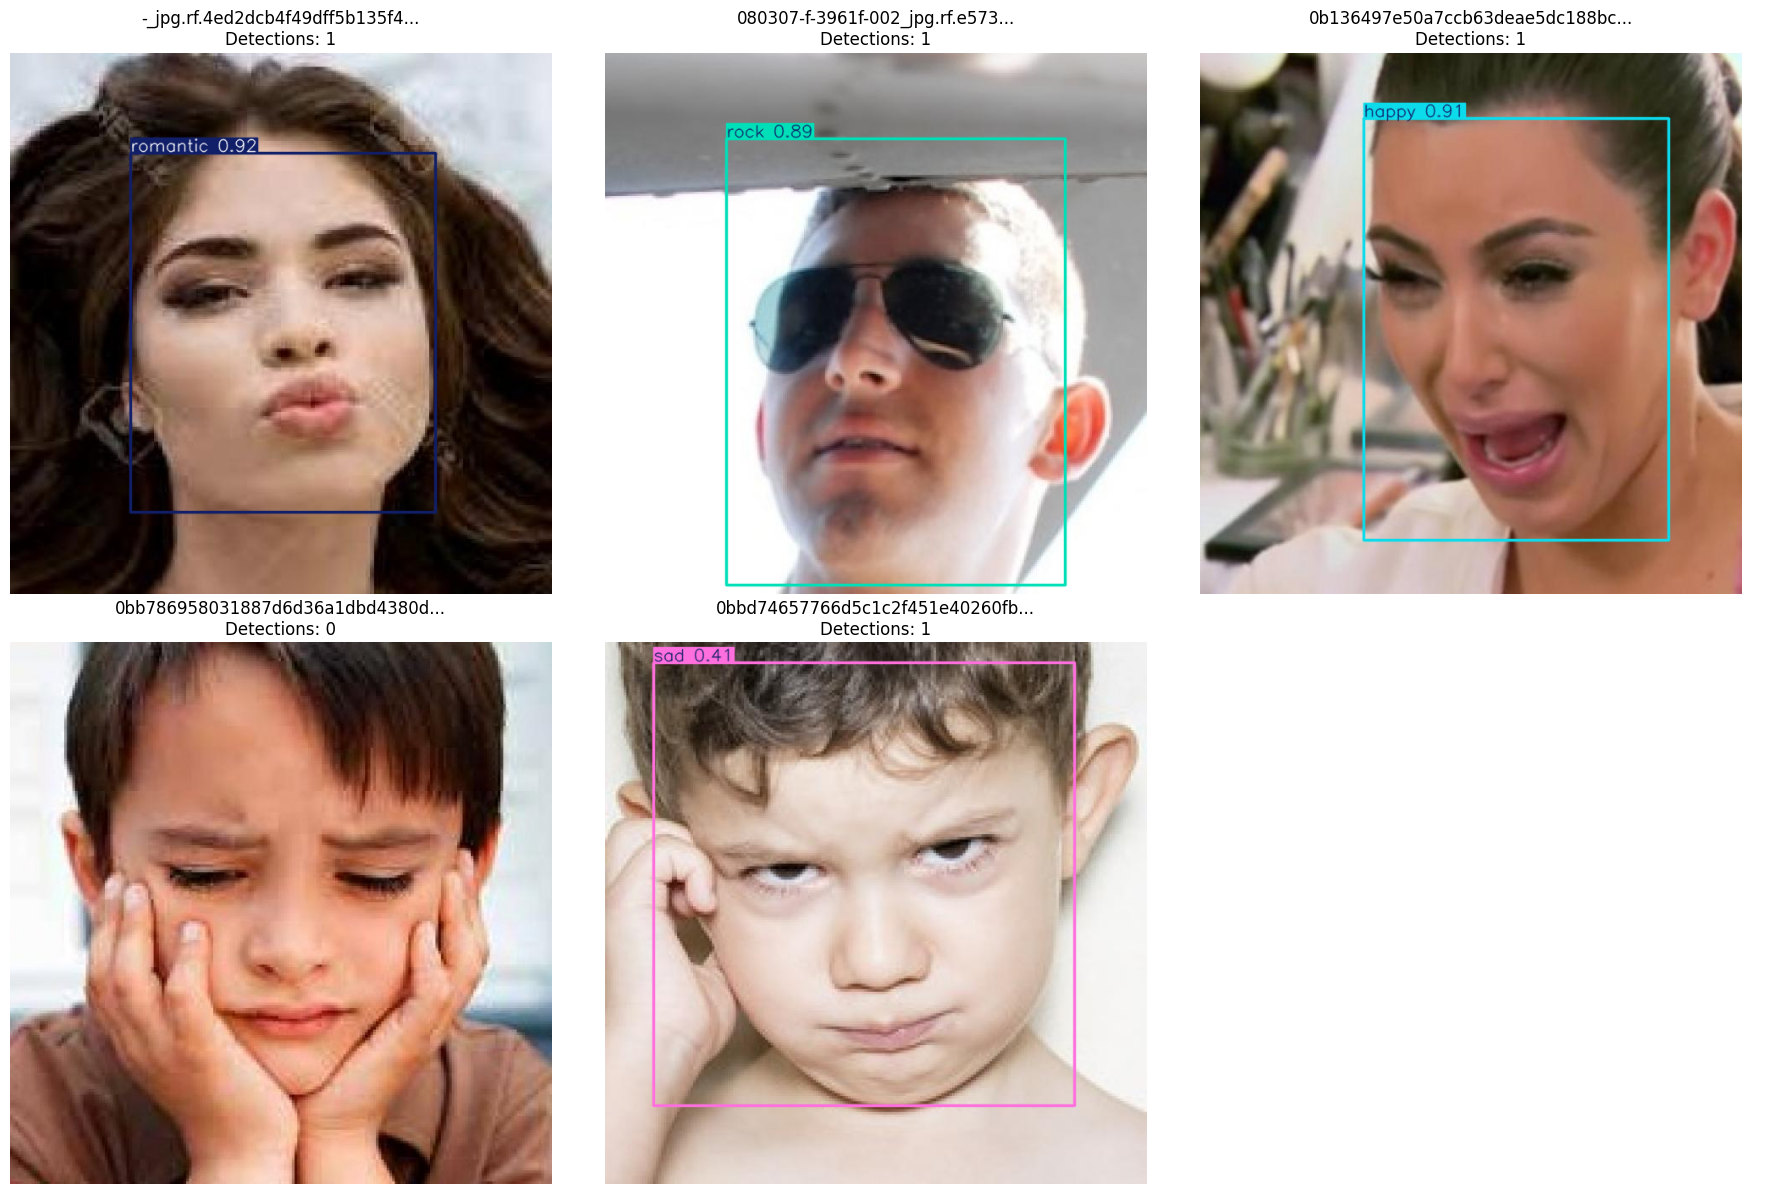

In [8]:
# Get a few test images
test_images_dir = Path("emotion-8/test/images")
test_images = list(test_images_dir.glob("*.jpg"))[:5]  # Get first 5 images

print(f"Running inference on {len(test_images)} test images...\n")

# Create a figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, image_path in enumerate(test_images):
    # Run inference
    results = model(str(image_path), conf=0.25, verbose=False)
    
    # Get annotated image
    annotated_img = results[0].plot()
    annotated_img_rgb = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)
    
    # Display in subplot
    axes[idx].imshow(annotated_img_rgb)
    axes[idx].axis('off')
    axes[idx].set_title(f"{image_path.name[:30]}...\nDetections: {len(results[0].boxes)}")
    
    # Print details
    print(f"Image: {image_path.name}")
    for box in results[0].boxes:
        class_id = int(box.cls[0])
        confidence = float(box.conf[0])
        class_name = results[0].names[class_id]
        print(f"  - {class_name}: {confidence:.2%}")
    print()

# Hide unused subplot
if len(test_images) < len(axes):
    axes[-1].axis('off')

plt.tight_layout()
plt.show()

## Save Inference Results

In [9]:
# Run inference and save results
SAVE_DIR = "inference_results"
os.makedirs(SAVE_DIR, exist_ok=True)

# Run inference on test images with save option
results = model(
    "emotion-8/test/images",
    conf=0.25,
    save=True,
    project=SAVE_DIR,
    name="test_predictions"
)

print(f"\nInference results saved to: {SAVE_DIR}/test_predictions")

Results saved to D:\FIle Aku\runs\detect\inference_results\test_predictions

Inference results saved to: inference_results/test_predictions


## Video Processing

In [ ]:
def process_video_with_stats(video_path, output_path, conf=0.25):
    """
    Process video file with emotion detection and collect statistics

    """
    import cv2
    from collections import defaultdict
    
    # Open video
    cap = cv2.VideoCapture(video_path)
    
    # Get video properties
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    print(f"Video properties:")
    print(f"  FPS: {fps}")
    print(f"  Resolution: {width}x{height}")
    print(f"  Total frames: {total_frames}")
    print(f"  Duration: {total_frames/fps:.2f} seconds")
    
    # Create video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    
    # Statistics
    emotion_counts = defaultdict(int)
    frame_count = 0
    
    print("\nProcessing video...")
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        frame_count += 1
        
        # Run inference on frame
        results = model(frame, conf=conf, verbose=False)
        
        # Count emotions
        for box in results[0].boxes:
            class_id = int(box.cls[0])
            class_name = results[0].names[class_id]
            emotion_counts[class_name] += 1
        
        # Get annotated frame
        annotated_frame = results[0].plot()
        
        # Write frame
        out.write(annotated_frame)
        
        # Progress indicator
        if frame_count % 30 == 0:
            progress = (frame_count / total_frames) * 100
            print(f"  Progress: {progress:.1f}% ({frame_count}/{total_frames} frames)")
    
    # Release resources
    cap.release()
    out.release()
    
    print(f"\n✓ Video processing complete!")
    print(f"  Output saved to: {output_path}")
    print(f"\nEmotion detections in video:")
    for emotion, count in sorted(emotion_counts.items(), key=lambda x: x[1], reverse=True):
        print(f"  {emotion:15} : {count:5} detections")
    
    return emotion_counts

# Example usage
VIDEO_PATH = "sample_video.mp4"
OUTPUT_PATH = "inference_results/output_video_annotated.mp4"

# Uncomment to process video
if os.path.exists(VIDEO_PATH):
    os.makedirs("inference_results", exist_ok=True)
    emotion_stats = process_video_with_stats(VIDEO_PATH, OUTPUT_PATH, conf=0.25)
else:
    print(f"Video not found: {VIDEO_PATH}")

Video properties:
  FPS: 30
  Resolution: 360x640
  Total frames: 4443
  Duration: 148.10 seconds

Processing video...
  Progress: 0.7% (30/4443 frames)
  Progress: 1.4% (60/4443 frames)
  Progress: 2.0% (90/4443 frames)
  Progress: 2.7% (120/4443 frames)
  Progress: 3.4% (150/4443 frames)
  Progress: 4.1% (180/4443 frames)
  Progress: 4.7% (210/4443 frames)
  Progress: 5.4% (240/4443 frames)
  Progress: 6.1% (270/4443 frames)
  Progress: 6.8% (300/4443 frames)
  Progress: 7.4% (330/4443 frames)
  Progress: 8.1% (360/4443 frames)
  Progress: 8.8% (390/4443 frames)
  Progress: 9.5% (420/4443 frames)
  Progress: 10.1% (450/4443 frames)
  Progress: 10.8% (480/4443 frames)
  Progress: 11.5% (510/4443 frames)
  Progress: 12.2% (540/4443 frames)
  Progress: 12.8% (570/4443 frames)
  Progress: 13.5% (600/4443 frames)
  Progress: 14.2% (630/4443 frames)
  Progress: 14.9% (660/4443 frames)
  Progress: 15.5% (690/4443 frames)
  Progress: 16.2% (720/4443 frames)
  Progress: 16.9% (750/4443 frames

### Real-time Webcam Inference

For real-time emotion detection from webcam

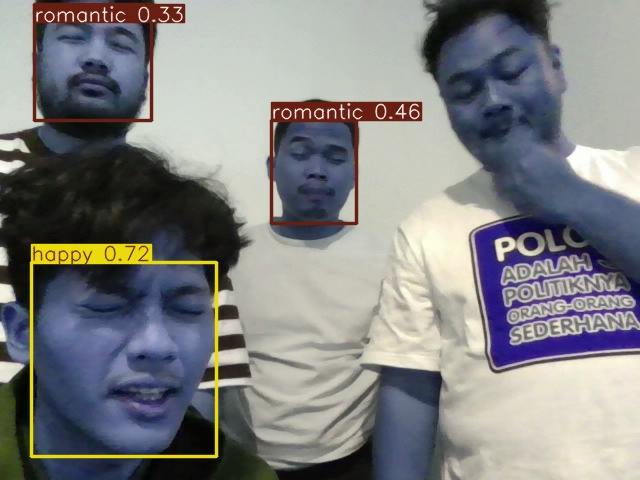

Frame: 300/300
Press Ctrl+C to stop

Processed 300 frames


In [ ]:
def webcam_inference(conf=0.25, max_frames=300):
    """
    Run real-time emotion detection on webcam feed

    """
    import cv2
    from IPython.display import display, Image, clear_output
    import time
    
    cap = cv2.VideoCapture(0)  
    
    if not cap.isOpened():
        print("Error: Could not open webcam")
        return
    
    print("Starting webcam inference...")
    print("Press Ctrl+C in cell to stop")
    
    frame_count = 0
    
    try:
        while frame_count < max_frames:
            ret, frame = cap.read()
            if not ret:
                print("Error: Failed to capture frame")
                break
            
            # Run inference
            results = model(frame, conf=conf, verbose=False)
            
            # Get annotated frame
            annotated_frame = results[0].plot()
            
            # Convert BGR to RGB
            rgb_frame = cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB)
            
            # Encode to JPEG
            _, buffer = cv2.imencode('.jpg', rgb_frame)
            jpg_bytes = buffer.tobytes()
            
            # Display in notebook
            clear_output(wait=True)
            display(Image(data=jpg_bytes, width=800))
            
            print(f"Frame: {frame_count + 1}/{max_frames}")
            print("Press Ctrl+C to stop")
            
            frame_count += 1
            
            # Small delay to control frame rate
            time.sleep(0.1)
            
    except KeyboardInterrupt:
        print("\nStopped by user")
    finally:
        cap.release()
        print(f"\nProcessed {frame_count} frames")

# Run webcam inference
webcam_inference(conf=0.25, max_frames=300)